# Chapter7: 합성곱 신경망(CNN)
---

##### 7.1 전체 구조   
이제까지 배웠던 Affline 계층(완전연결 계층)   
<img src="./img/ch7-1.png" width=800>   
CNN 예   
<img src="./img/ch7-2.png" width=800>   
* 기존의 Affline-ReLU 구조가 Conv-ReLU-Pooling으로 바뀜
* 출력에 가까운 층에서는 Affline-Relu 구조를 사용
* 마지막 출력에서는 Affline-Softmax 구조 사용

##### 7.2 합성곱 계층   
**기존의 완전연결 계층의 문제점**: 데이터 형상 무시   
    : 예로 입력이 이미지 데이터인 경우에 3차원 데이터(세로, 가로, 채널)를 1차원으로 평탄화 해줘야 한다. 이 경웨 형상에 담긴 정보가 소실된다.   
    
반면에, 합성곱 계층은 형상을 유지하여 3차원 데이터로 입력 받으며 3차원 데이터로 다음 계층에 전달한다.   
   
CNN에서는 합성곱 계층의 입출력 데이터를 특징 맵(feature map)이라고 한다. -> 입력 데이터 = 입력 특징 맵, 출력 데이터 = 출력 특징 맵

**합성곱 연산**   
<img src="./img/ch7-3.png" width=700>   
   
CNN에서 필터의 매개변수 = 가중치   
편향도 존재

**패딩**: 입력 데이터 주변을 특정 값으로 채우는 것 -> 출력 크기 조정   
 
<img src="./img/ch7-4.png" width=600>

**스트라이드**: 필터를 적용하는 위치의 간격   

<img src="./img/ch7-5.png" width=600>

입력 크기를 $(H, W)$, 필터 크기를 $(FH, FW)$, 출력 크기를 $(OH, OW)$, 패딩을 $P$, 스트라이드를 $S$라 할 때, 출력 크기는 다음과 같다.   

$OH = \frac{H + 2P - FH}{S} + 1$   

$OW = \frac{W + 2P - FW}{S} + 1$   
단, 출력 크기는 정수여야 한다.

**3차원 데이터 합성곱 연산**   

<img src="./img/ch7-6.png" width=700>

**합성곱 연산의 처리 흐름**   

<img src="./img/ch7-7.png" width=800>

**배치 처리**   

<img src="./img/ch7-8.png" width=800>

##### 7.3 폴링 계층   

폴링: 세로, 가로 방향의 공간을 줄이는 연산   

<img src="./img/ch7-9.jpg" wdith=400>   

폴링 계층의 특징
* 학습해야 할 매개변수가 없다.
* 채널 수가 변하지 않는다.
* 입력의 변화에 영향을 적게 받는다.


##### 7.4 합성곱/폴링 계층 구현


In [1]:
import numpy as np
# 4차원 배열 (데이터 개수, 채널 수, 높이, 너비)
x = np.random.rand(10, 1, 28, 28)
print(x.shape)
print(x[0].shape)
print(x[1].shape)

(10, 1, 28, 28)
(1, 28, 28)
(1, 28, 28)


**im2col로 데이터 전개하기**   

넘파이에서 for문을 사용하면 성능이 떨어지는 단점이 존재 -> im2col 함수 사용   

<img src="./img/ch7-10.png" width=600>

In [4]:
# im2col 예제
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7) # (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [6]:
# 합성곱 계층 구현
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T    # 필터 전개
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

<img src="./img/ch7-11.png" width=600>

In [7]:
# 폴링 계층 구현
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride 
        self.pad = pad
    
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 입력 데이터 전개
        col = im2col(x, self.pool_h, self.pool_w, stride=1, pad=0)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        # 행별 최댓값
        out = np.max(col, axis=1)
        
        # 적절한 모양으로 성형
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

##### 7.5 CNN 구현하기    

<img src="./img/ch7-12.png" width=600>

In [11]:
from collections import OrderedDict
from common.layers import *

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        # 가중치 매개변수 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # CNN 구성 계층
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], self.params['stride'], self.params['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward()
            
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    # 오차 역전파법으로 기울기 구현
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)
        
        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads

Saved Network Parameters!


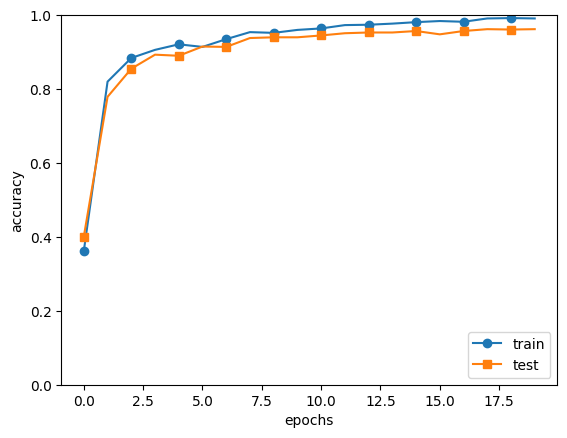

In [13]:
# MNIST dataset to CNN
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

##### 7.6 CNN 시각화하기   


학습 전


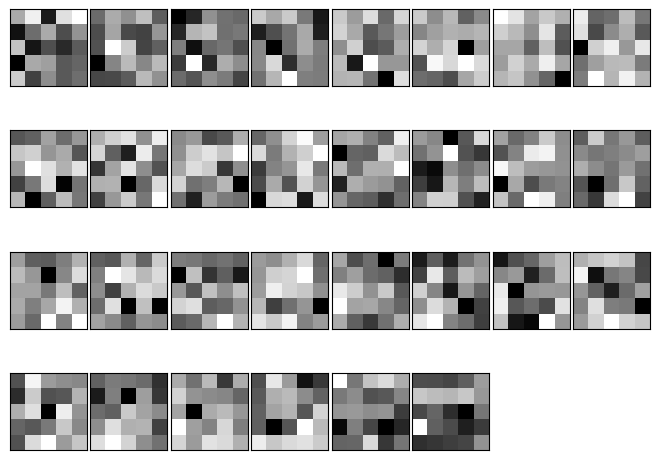

학습 후


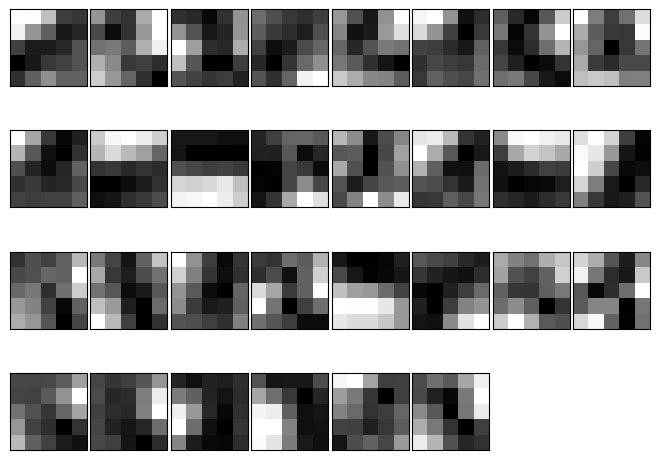

In [15]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
print("학습 전")
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
print("학습 후")
filter_show(network.params['W1'])

**층 깊이에 따른 추출 정보 변화**   
: 층이 깊어지면서 뉴런이 반응하는 대상이 단순한 모양에서 고급 정보로 변화해간다. -> 사물의 의미를 이해하도록 변화

<img src="./img/ch7-13.png" width=800>

##### 7.7 대표적인 CNN

**LeNet**: CNN의 원조, 손글씨 숫자를 인식하는 네트워크   

<img src="./img/ch7-14.png" width=1000>

**AlexdNet**
* 활성화 함수로 ReLU 사용
* 국소적 정규화를 실시하는 계층을 이용
* 드롭아웃을 사용   

<img src="./img/ch7-15.png" width=1000>

##### 7.8 정리